In [1]:
import os,re,numpy as np, pandas as pd, cvxpy as cp, scipy as scp, seaborn as sns, pickle as pkl
from importlib import reload

C:\Users\nlgun\AppData\Roaming\Python\Python311\site-packages\scikits\__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)


In [30]:
def loadorsave(loader,saver):
    '''
    Createst a function to load or save object to file
    using loader and saver functions.
    The loader should take a file path and return the object.
    The saver should take a file path and an object to save.
    If obj is None, load the object from file.
    If obj is not None and the path doesn't exist or FORCE,
    save the object to file, overwriting if necessary.
    Else return None
    '''
    def lrs_(path,obj=None, FORCE=False):
    
        if obj is None:
            return loader(path)
        elif not os.path.exists(path) or FORCE:
            saver(path,obj)
            return path
        else:
            return None
    return lrs_
        
managepkl = loadorsave(lambda path: pkl.load(open(path,'rb')), lambda path, obj: pkl.dump(obj,open(path,'wb')))
manageparquet = loadorsave(lambda path: pd.read_parquet(path), lambda path, obj: obj.to_parquet(path))
managecsv = loadorsave(lambda path: pd.read_csv(path), lambda path, obj: obj.to_csv(path))


# Data

## From File

In [6]:
data = manageparquet(r'Downloads\snp500_240529_250529.parquet')
data.iloc[:5,:5]

Price        Adj Close                                                
Ticker               A        AAPL        ABBV        ABNB         ABT
Date                                                                  
2024-05-29  144.405426  189.404221  149.363983  146.610001   98.750374
2024-05-30  130.449280  190.399567  150.830688  145.520004   99.740509
2024-05-31  129.446762  191.355103  155.587891  144.929993  100.181679
2024-06-03  130.429443  193.126785  154.574692  146.250000  100.848312
2024-06-04  129.883499  193.445312  156.456345  147.080002  101.397301

In [4]:
infod =managepkl(r'Downloads\stock_info_dict.pkl')

In [5]:
infod['A']

{'address1': '5301 Stevens Creek Boulevard',
 'city': 'Santa Clara',
 'state': 'CA',
 'zip': '95051',
 'country': 'United States',
 'phone': '800 227 9770',
 'fax': '866 497 1134',
 'website': 'https://www.agilent.com',
 'industry': 'Diagnostics & Research',
 'industryKey': 'diagnostics-research',
 'industryDisp': 'Diagnostics & Research',
 'sector': 'Healthcare',
 'sectorKey': 'healthcare',
 'sectorDisp': 'Healthcare',
 'longBusinessSummary': "Agilent Technologies, Inc. provides application focused solutions to the life sciences, diagnostics, and applied chemical markets worldwide. The company operates in three segments: Life Sciences and Applied Markets, Diagnostics and Genomics, and Agilent CrossLab. The Life Sciences and Applied Markets segment offers liquid chromatography systems and components; liquid chromatography mass spectrometry systems; gas chromatography systems and components; gas chromatography mass spectrometry systems; inductively coupled plasma mass spectrometry instr

In [7]:
adjc = data['Adj Close']
adjc.iloc[:5,:5]

Ticker,A,AAPL,ABBV,ABNB,ABT
Date,,,,,
2024-05-29,144.405426,189.404221,149.363983,146.610001,98.750374
2024-05-30,130.449280,190.399567,150.830688,145.520004,99.740509
2024-05-31,129.446762,191.355103,155.587891,144.929993,100.181679
2024-06-03,130.429443,193.126785,154.574692,146.250000,100.848312
2024-06-04,129.883499,193.445312,156.456345,147.080002,101.397301


In [8]:
returns = adjc.pct_change().dropna(axis=0,how='all')

In [33]:
snpdivmcap = managecsv('Downloads\sp-500-index-05-31-2025.csv').set_index('Symbol').iloc[:-1,:2]
snpdivmcap

,Name,Market Cap
Symbol,,
A,Agilent Technologies,3.190873e+10
AAPL,Apple Inc,2.999861e+12
ABBV,Abbvie Inc,3.287452e+11
ABNB,Airbnb Inc Cl A,8.080728e+10
ABT,Abbott Laboratories,2.324073e+11
...,...,...
XYL,Xylem Inc,3.067196e+10
YUM,Yum+ACE- Brands,4.001028e+10
ZBH,Zimmer Biomet Holdings,1.823565e+10


In [34]:
idx = snpdivmcap.index.intersection(returns.columns)
idx

Index(['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACGL', 'ACN', 'ADBE', 'ADI', 'ADM',
       ...
       'WTW', 'WY', 'WYNN', 'XEL', 'XOM', 'XYL', 'YUM', 'ZBH', 'ZBRA', 'ZTS'],
      dtype='object', length=501)

In [35]:
dy = pd.Series([infod[k].get('dividendYield',0) for k in idx])
dy

0      0.89
1      0.52
2      3.52
3      0.00
4      1.77
       ... 
496    1.27
497    1.97
498    1.04
499    0.00
500    1.19
Length: 501, dtype: float64

In [36]:
dyz = (dy - dy.mean())/dy.std()

In [37]:
snpdivmcap = snpdivmcap.loc[idx].dropna(how='all',axis=0).assign\
(weight = snpdivmcap['Market Cap']/(snpdivmcap['Market Cap'].sum()),\
# dy = snpdivmcap['Div Yield(a)'].str.replace('%','').astype(float))
 dy = dy.values,dyz=dyz.values)

In [38]:
# dy = snpdivmcap.dy
# snpdivmcap = snpdivmcap.assign(dyz = dyz)#(dy - dy.mean())/dy.std())
snpdivmcap

,Name,Market Cap,weight,dy,dyz
A,Agilent Technologies,3.190873e+10,0.000578,0.89,-0.607507
AAPL,Apple Inc,2.999861e+12,0.054377,0.52,-0.817490
ABBV,Abbvie Inc,3.287452e+11,0.005959,3.52,0.885071
ABNB,Airbnb Inc Cl A,8.080728e+10,0.001465,0.00,-1.112601
ABT,Abbott Laboratories,2.324073e+11,0.004213,1.77,-0.108089
...,...,...,...,...,...
XYL,Xylem Inc,3.067196e+10,0.000556,1.27,-0.391850
YUM,Yum+ACE- Brands,4.001028e+10,0.000725,1.97,0.005415
ZBH,Zimmer Biomet Holdings,1.823565e+10,0.000331,1.04,-0.522379
ZBRA,Zebra Technologies,1.473596e+10,0.000267,0.00,-1.112601


In [47]:
cov = returns.loc[:,idx].cov()
cov.iloc[:,:5]

,A,AAPL,ABBV,ABNB,ABT
A,0.000381,0.000175,0.000130,0.000199,0.000065
AAPL,0.000175,0.000437,0.000078,0.000279,0.000023
ABBV,0.000130,0.000078,0.000319,0.000040,0.000091
ABNB,0.000199,0.000279,0.000040,0.000682,0.000011
ABT,0.000065,0.000023,0.000091,0.000011,0.000175
...,...,...,...,...,...
XYL,0.000160,0.000171,0.000078,0.000182,0.000056
YUM,0.000085,0.000084,0.000083,0.000074,0.000046
ZBH,0.000095,0.000047,0.000097,0.000059,0.000078
ZBRA,0.000307,0.000302,0.000101,0.000349,0.000034


In [41]:
assert abs(snpdivmcap.dyz.std()-1)<1e-7

In [42]:
mcapweights = snpdivmcap.weight
mcapweights /=mcapweights.sum() # IMPORTANT - otherwise will get inf
mcapweights.sum()

1.0

# Minimum Variance Problem and Solution

In [43]:
import cvxpy as cp

In [44]:
w = cp.Variable(len(cov))

wa = w - mcapweights
error = cp.norm((cov.values + 0.0001*np.eye(len(cov)))@wa)
prob = cp.Problem(cp.Minimize(error),[wa.T@dyz.values == 0.5, #empirical - point along dyz
                                      w>=0, # long only
                                      cp.sum(w)==1]) # full investment
                                      # cp.sum(wa) ==0]) #  redundant

In [45]:
prob.solve()

8.933200601467167e-06

## Check Increased Dividends

In [46]:
snpdivmcap.loc[idx].dy.values.dot(w.value),snpdivmcap.loc[idx].dy.values.dot(mcapweights),

(2.169832047561443, 1.2888065103574473)

In [48]:
snpdivmcap.assign(MCap = snpdivmcap['Market Cap']/1e6).drop('Market Cap',axis=1).rename(columns = {'MCap':'Market Cap ($MM)'}).sort_values('dy',ascending=False).head(50)\
.style.format({'Market Cap ($MM)':'{:,.0f}'})

,Name,weight,dy,dyz,Market Cap ($MM)
DOW,Dow Inc,0.000363,10.090000,4.613681,"19,608"
LYB,Lyondellbasell Industries NV,0.000336,9.700000,4.392348,"18,156"
WBA,Walgreens Boots Alliance,0.000180,8.890000,3.932656,"9,728"
ARE,Alexandria Real Estate Equities,0.000225,7.520000,3.155153,"12,142"
PFE,Pfizer Inc,0.002470,7.320000,3.041649,"133,549"
F,Ford Motor Company,0.000764,7.230000,2.990572,"41,277"
DOC,Healthpeak Properties Inc,0.000224,7.010000,2.865718,"12,095"
AES,The Aes Corp,0.000133,6.910000,2.808966,"7,183"
UPS,United Parcel Service,0.001528,6.730000,2.706812,"82,597"
MO,Altria Group,0.001889,6.730000,2.706812,"102,095"


In [49]:
(tiltdf := pd.DataFrame({'tilted':w.value,
                         'snp':mcapweights,'yield':dy.values},index = idx)\
 .sort_values('tilted',ascending=False).round(4))
tiltdf = tiltdf.assign(delta = tiltdf.tilted - tiltdf.snp)
tiltdf

,tilted,snp,yield,delta
MSFT,0.0640,0.0633,0.72,0.0007
NVDA,0.0568,0.0610,0.03,-0.0042
AAPL,0.0425,0.0555,0.52,-0.0130
META,0.0425,0.0301,0.32,0.0124
GOOGL,0.0380,0.0386,0.49,-0.0006
...,...,...,...,...
APTV,0.0000,0.0003,0.00,-0.0003
WYNN,0.0000,0.0002,1.10,-0.0002
WBD,0.0000,0.0005,0.00,-0.0005
ENPH,0.0000,0.0001,0.00,-0.0001


## Effect of Rounding on Number of Stocks in Solution

In [50]:
(tiltdf := pd.DataFrame({'tilted':w.value,
                         'snp':mcapweights,'yield':dy.values},index = idx)\
 .sort_values('tilted',ascending=False).round(4))
tiltdf = tiltdf.assign(delta = tiltdf.tilted - tiltdf.snp)
tiltdf_ = tiltdf[tiltdf.tilted.round(2)>0]
len(tiltdf_)

56

## Sorts

In [51]:
pd.concat([tiltdf,snpdivmcap[['Name']]],axis=1).sort_values('delta',ascending=False)

,tilted,snp,yield,delta,Name
MO,0.0187,0.0019,6.73,0.0168,Altria Group
LYB,0.0167,0.0003,9.70,0.0164,Lyondellbasell Industries NV
TROW,0.0146,0.0004,5.43,0.0142,T Rowe Price Group
DOW,0.0136,0.0004,10.09,0.0132,Dow Inc
META,0.0425,0.0301,0.32,0.0124,Meta Platforms Inc
...,...,...,...,...,...
ABBV,0.0000,0.0061,3.52,-0.0061,Abbvie Inc
BAC,0.0000,0.0061,2.36,-0.0061,Bank of America Corp
JNJ,0.0001,0.0069,3.35,-0.0068,Johnson +ACY- Johnson
XOM,0.0000,0.0082,3.87,-0.0082,Exxon Mobil Corp


In [52]:
pd.concat([tiltdf,snpdivmcap[['Name']]],axis=1).sort_values('snp',ascending=False)

,tilted,snp,yield,delta,Name
MSFT,0.0640,0.0633,0.72,0.0007,Microsoft Corp
NVDA,0.0568,0.0610,0.03,-0.0042,Nvidia Corp
AAPL,0.0425,0.0555,0.52,-0.0130,Apple Inc
AMZN,0.0368,0.0403,0.00,-0.0035,Amazon.com Inc
GOOG,0.0356,0.0388,0.49,-0.0032,Alphabet Cl C
...,...,...,...,...,...
IVZ,0.0044,0.0001,5.81,0.0043,Invesco Plc
LW,0.0000,0.0001,2.65,-0.0001,Lamb Weston Holdings Inc
GNRC,0.0000,0.0001,0.00,-0.0001,Generac Holdings Inc
APA,0.0000,0.0001,5.88,-0.0001,Apa Corp


## Graph

Text(0.5, 1.0, 'tilted vs market weights for S&P 500\ntilt based on dividend yield')

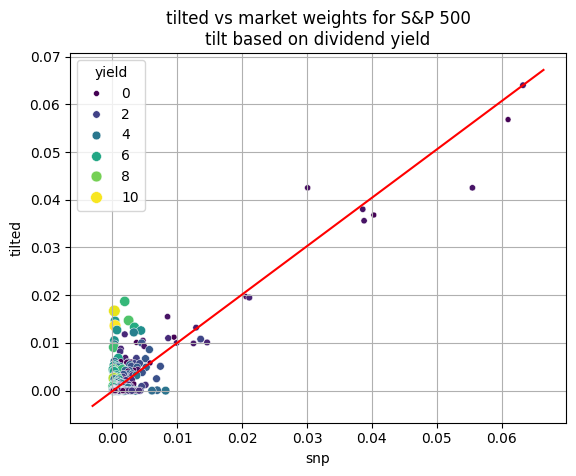

In [53]:
title = 'tilted vs market weights for S&P 500\ntilt based on dividend yield'
ax = sns.scatterplot(data = tiltdf,x='snp',y='tilted',
                     size = 'yield',hue='yield',palette='viridis',
                    )
ax.plot(ax.get_xlim(),ax.get_ylim(),c='red')
ax.grid(True)
ax.set_title(title)